<a href="https://colab.research.google.com/github/vince-camm/GENAIHW6/blob/main/Homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vincent Cammisa
Generative AI
Assignment #6

Generating cello pieces in a stylistic manor, representative of Bach

In [3]:
!apt-get install musescore
!apt-get install music21
!apt-get install fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  desktop-file-utils fonts-freefont-ttf libevdev2 libgudev-1.0-0 libinput-bin libinput10 libmd4c0
  libmtdev1 libportaudio2 libportmidi0 libqt5core5a libqt5dbus5 libqt5gui5 libqt5help5
  libqt5network5 libqt5printsupport5 libqt5qml5 libqt5qmlmodels5 libqt5qmlworkerscript5
  libqt5quick5 libqt5sql5 libqt5sql5-sqlite libqt5svg5 libqt5widgets5 libqt5xml5 libqt5xmlpatterns5
  libwacom-bin libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1 libxkbcommon-x11-0
  musescore-common musescore-general-soundfont-small qml-module-qt-labs-folderlistmodel
  qml-module-qt-labs-settings qml-module-qtgraphicaleffects qml-module-qtqml
  qml-module-qtqml-models2 qml-module-qtquick-controls qml-module-qtquick-dialogs
  qml-module-qtquick-layouts qml-module-qtquick

In [4]:
!apt-get install musescore3

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpoppler-qt5-1 musescore3-common
Suggested packages:
  pulseaudio-utils
The following NEW packages will be installed:
  libpoppler-qt5-1 musescore3 musescore3-common
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 11.1 MB of archives.
After this operation, 54.0 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 libpoppler-qt5-1 amd64 22.02.0-2ubuntu0.5 [178 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 musescore3-common all 3.2.3+dfsg2-11 [3,586 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 musescore3 amd64 3.2.3+dfsg2-11 [7,291 kB]
Fetched 11.1 MB in 2s (6,014 kB/s)
Selecting previously unselected package libpoppler-qt5-1:amd64.
(Reading database ... 125691 files and directories currently installed.)
Preparing to

In [5]:
!which musescore3

/usr/bin/musescore3


In [6]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
import os
import glob
import numpy as np
import time
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, losses, callbacks

import music21

In [8]:
import os
import pickle as pkl
import music21
import keras
import tensorflow as tf

from fractions import Fraction


def parse_midi_files(file_list, parser, seq_len, parsed_data_path=None):
    notes_list = []
    duration_list = []
    notes = []
    durations = []

    for i, file in enumerate(file_list):
        print(i + 1, "Parsing %s" % file)
        score = parser.parse(file).chordify()

        notes = ["START"]  # Initialize notes for this file
        durations = ["0.0"]  # Initialize durations for this file

        for element in score.flat:
            note_name = None
            duration_name = None

            if isinstance(element, music21.key.Key):
                note_name = str(element.tonic.name) + ":" + str(element.mode)
                duration_name = "0.0"

            elif isinstance(element, music21.meter.TimeSignature):
                note_name = str(element.ratioString) + "TS"
                duration_name = "0.0"

            elif isinstance(element, music21.chord.Chord):
                note_name = element.pitches[-1].nameWithOctave
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Rest):
                note_name = str(element.name)
                duration_name = str(element.duration.quarterLength)

            elif isinstance(element, music21.note.Note):
                note_name = str(element.nameWithOctave)
                duration_name = str(element.duration.quarterLength)

            if note_name and duration_name:
                notes.append(note_name)
                durations.append(duration_name)

        print(f"{len(notes)} notes parsed")

        # Build sequences for this file and add to the main lists
        for i in range(len(notes) - seq_len):
            notes_list.append(" ".join(notes[i : (i + seq_len)]))
            duration_list.append(" ".join(durations[i : (i + seq_len)]))

    if parsed_data_path:
        # Ensure parsed_data_path is a directory
        parsed_data_path = os.path.dirname(parsed_data_path)  # Extract directory part
        # Create the directory if it doesn't exist
        os.makedirs(parsed_data_path, exist_ok=True)
        with open(os.path.join(parsed_data_path, "notes"), "wb") as f:
            pkl.dump(notes_list, f)
        with open(os.path.join(parsed_data_path, "durations"), "wb") as f:
            pkl.dump(duration_list, f)  # Store the duration_list

    return notes_list, duration_list


def load_parsed_files(parsed_data_path):
    with open(os.path.join(parsed_data_path, "notes"), "rb") as f:
        notes = pkl.load(f)
    with open(os.path.join(parsed_data_path, "durations"), "rb") as f:
        durations = pkl.load(f)
    return notes, durations


def get_midi_note(sample_note, sample_duration):
    new_note = None

    if "TS" in sample_note:
        new_note = music21.meter.TimeSignature(sample_note.split("TS")[0])

    elif "major" in sample_note or "minor" in sample_note:
        tonic, mode = sample_note.split(":")
        new_note = music21.key.Key(tonic, mode)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif "." in sample_note:
        notes_in_chord = sample_note.split(".")
        chord_notes = []
        for current_note in notes_in_chord:
            n = music21.note.Note(current_note)
            n.duration = music21.duration.Duration(
                float(Fraction(sample_duration))
            )
            n.storedInstrument = music21.instrument.Violoncello()
            chord_notes.append(n)
        new_note = music21.chord.Chord(chord_notes)

    elif sample_note == "rest":
        new_note = music21.note.Rest()
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    elif sample_note != "START":
        new_note = music21.note.Note(sample_note)
        new_note.duration = music21.duration.Duration(
            float(Fraction(sample_duration))
        )
        new_note.storedInstrument = music21.instrument.Violoncello()

    return new_note


class SinePositionEncoding(keras.layers.Layer):
    """Sinusoidal positional encoding layer.
    This layer calculates the position encoding as a mix of sine and cosine
    functions with geometrically increasing wavelengths. Defined and formulized
    in [Attention is All You Need](https://arxiv.org/abs/1706.03762).
    Takes as input an embedded token tensor. The input must have shape
    [batch_size, sequence_length, feature_size]. This layer will return a
    positional encoding the same size as the embedded token tensor, which
    can be added directly to the embedded token tensor.
    Args:
        max_wavelength: The maximum angular wavelength of the sine/cosine
            curves, as described in Attention is All You Need. Defaults to
            10000.
    Examples:
    ```python
    # create a simple embedding layer with sinusoidal positional encoding
    seq_len = 100
    vocab_size = 1000
    embedding_dim = 32
    inputs = keras.Input((seq_len,), dtype=tf.float32)
    embedding = keras.layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim
    )(inputs)
    positional_encoding = keras_nlp.layers.SinePositionEncoding()(embedding)
    outputs = embedding + positional_encoding
    ```
    References:
     - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)
    """

    def __init__(
        self,
        max_wavelength=10000,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.max_wavelength = max_wavelength

    def call(self, inputs):
        # TODO(jbischof): replace `hidden_size` with`hidden_dim` for consistency
        # with other layers.
        input_shape = tf.shape(inputs)
        # length of sequence is the second last dimension of the inputs
        seq_length = input_shape[-2]
        hidden_size = input_shape[-1]
        position = tf.cast(tf.range(seq_length), self.compute_dtype)
        min_freq = tf.cast(1 / self.max_wavelength, dtype=self.compute_dtype)
        timescales = tf.pow(
            min_freq,
            tf.cast(2 * (tf.range(hidden_size) // 2), self.compute_dtype)
            / tf.cast(hidden_size, self.compute_dtype),
        )
        angles = tf.expand_dims(position, 1) * tf.expand_dims(timescales, 0)
        # even indices are sine, odd are cosine
        cos_mask = tf.cast(tf.range(hidden_size) % 2, self.compute_dtype)
        sin_mask = 1 - cos_mask
        # embedding shape is [seq_length, hidden_size]
        positional_encodings = (
            tf.sin(angles) * sin_mask + tf.cos(angles) * cos_mask
        )

        return tf.broadcast_to(positional_encodings, input_shape)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_wavelength": self.max_wavelength,
            }
        )
        return config

## TASK 1
Data Preparation: Convert MIDI files into sequences of notes and durations.


In [9]:
PARSE_MIDI_FILES = True
PARSED_DATA_PATH = "/usr/bin/musescore3"
DATASET_REPETITIONS = 1

SEQ_LEN = 50
EMBEDDING_DIM = 256
KEY_DIM = 256
N_HEADS = 5
DROPOUT_RATE = 0.3
FEED_FORWARD_DIM = 256
LOAD_MODEL = False

# optimization
EPOCHS = 100
BATCH_SIZE = 128

GENERATE_LEN = 50

In [10]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [11]:
file_list = glob.glob("/content/drive/MyDrive/*.mid")
print(f"Found {len(file_list)} midi files")

Found 57 midi files


In [12]:
parser = music21.converter

In [13]:
example_score = (
    music21.converter.parse(file_list[1]).splitAtQuarterLength(12)[0].chordify()
)

In [14]:
example_score.show("text")


{0.0} <music21.metadata.Metadata object at 0x78dfe6dcc8b0>
{0.0} <music21.stream.Measure 1 offset=0.0>
    {0.0} <music21.instrument.Violoncello 'Solo Cello: Solo Cello'>
    {0.0} <music21.instrument.Violoncello 'Violoncello'>
    {0.0} <music21.clef.BassClef>
    {0.0} <music21.tempo.MetronomeMark allegretto Quarter=110>
    {0.0} <music21.key.Key of D major>
    {0.0} <music21.meter.TimeSignature 3/2>
    {0.0} <music21.chord.Chord D3 A3 F#4>
    {2.0} <music21.chord.Chord A3 F#4>
    {5.0} <music21.chord.Chord G4>
{6.0} <music21.stream.Measure 2 offset=6.0>
    {0.0} <music21.chord.Chord G2 G3 B3 E4>
    {1.0} <music21.chord.Chord G2 G3 B3 C#4>
    {2.0} <music21.chord.Chord F#3 D4>
    {5.0} <music21.chord.Chord B4>


In [15]:
if PARSE_MIDI_FILES:
    notes, durations = parse_midi_files(
        file_list, parser, SEQ_LEN + 1, PARSED_DATA_PATH
    )
else:
    notes, durations = load_parsed_files()

1 Parsing /content/drive/MyDrive/cs5-4sar.mid


<ipython-input-15-04172d0f16ff>:2: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  notes, durations = parse_midi_files(


219 notes parsed
2 Parsing /content/drive/MyDrive/cs6-4sar.mid
335 notes parsed
3 Parsing /content/drive/MyDrive/cs4-6gig.mid
971 notes parsed
4 Parsing /content/drive/MyDrive/cs6-5gav.mid
806 notes parsed
5 Parsing /content/drive/MyDrive/cs4-4sar.mid
320 notes parsed
6 Parsing /content/drive/MyDrive/cs6-3cou.mid
1286 notes parsed
7 Parsing /content/drive/MyDrive/cs2-3cou.mid
741 notes parsed
8 Parsing /content/drive/MyDrive/cs1-6gig.mid
426 notes parsed
9 Parsing /content/drive/MyDrive/cs2-6gig.mid
735 notes parsed
10 Parsing /content/drive/MyDrive/cs2-5men.mid
527 notes parsed
11 Parsing /content/drive/MyDrive/cs4-1pre.mid
817 notes parsed
12 Parsing /content/drive/MyDrive/cs6-6gig.mid
1172 notes parsed
13 Parsing /content/drive/MyDrive/cs1-4sar.mid
263 notes parsed
14 Parsing /content/drive/MyDrive/cs2-4sar.mid
337 notes parsed
15 Parsing /content/drive/MyDrive/cs1-5men.mid
647 notes parsed
16 Parsing /content/drive/MyDrive/cs4-2all.mid
1055 notes parsed
17 Parsing /content/drive/My

In [16]:
example_notes = notes[658]
if len(durations) > 658:
    example_durations = durations[658]
else:
    example_durations = None
    print("durations list is too short. Using default value for example_durations.")
print("\nNotes string\n", example_notes, "...")
print("\nDuration string\n", example_durations, "...")


Notes string
 D4 A3 B-3 E-3 D3 E-3 C3 E-3 B-2 A2 E-3 G2 A2 E-3 F2 B-2 D3 F3 B-3 D3 F3 B-2 B-3 B-3 A3 B-3 F3 G3 A3 B-3 A3 B-3 D4 C4 D4 B-3 A3 B-3 F3 G3 A3 B-2 D4 D4 C4 D4 G#3 G3 G#3 F3 E-3 ...

Duration string
 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 2.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 2.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...


## TASK 2
Tokenization: Convert the notes and durations into tokens that the Transformer model can understand.


In [17]:
def create_dataset(elements):
    ds = (
        tf.data.Dataset.from_tensor_slices(elements)
        .batch(BATCH_SIZE, drop_remainder=True)
        .shuffle(1000)
    )
    vectorize_layer = layers.TextVectorization(
        standardize=None, output_mode="int"
    )
    vectorize_layer.adapt(ds)
    vocab = vectorize_layer.get_vocabulary()
    return ds, vectorize_layer, vocab


notes_seq_ds, notes_vectorize_layer, notes_vocab = create_dataset(notes)
durations_seq_ds, durations_vectorize_layer, durations_vocab = create_dataset(
    durations
)
seq_ds = tf.data.Dataset.zip((notes_seq_ds, durations_seq_ds))

In [18]:
# Display the same example notes and durations converted to ints
example_tokenised_notes = notes_vectorize_layer(example_notes)
example_tokenised_durations = durations_vectorize_layer(example_durations)
print("{:10} {:10}".format("note token", "duration token"))
for i, (note_int, duration_int) in enumerate(
    zip(
        example_tokenised_notes.numpy()[:11],
        example_tokenised_durations.numpy()[:11],
    )
):
    print(f"{note_int:10}{duration_int:10}")

note token duration token
         7         3
         3         3
        11         3
        10         3
         4         3
        10         3
        13         3
        10         3
        20         3
        19         3
        10         3


In [19]:
notes_vocab_size = len(notes_vocab)
durations_vocab_size = len(durations_vocab)

# Display some token:note mappings
print(f"\nNOTES_VOCAB: length = {len(notes_vocab)}")
for i, note in enumerate(notes_vocab[:10]):
    print(f"{i}: {note}")

print(f"\nDURATIONS_VOCAB: length = {len(durations_vocab)}")
# Display some token:duration mappings
for i, note in enumerate(durations_vocab[:10]):
    print(f"{i}: {note}")


NOTES_VOCAB: length = 59
0: 
1: [UNK]
2: G3
3: A3
4: D3
5: F3
6: C4
7: D4
8: E3
9: B3

DURATIONS_VOCAB: length = 24
0: 
1: [UNK]
2: 0.25
3: 0.5
4: 1.0
5: 1/3
6: 0.75
7: 1/12
8: 1.5
9: 1/6


## TASK 3
Model Architecture: Build a Transformer-based architecture that processes musical notes and durations to generate new sequences.

In [20]:
# Create the training set of sequences and the same sequences shifted by one note
def prepare_inputs(notes, durations):
    notes = tf.expand_dims(notes, -1)
    durations = tf.expand_dims(durations, -1)
    tokenized_notes = notes_vectorize_layer(notes)
    tokenized_durations = durations_vectorize_layer(durations)
    x = (tokenized_notes[:, :-1], tokenized_durations[:, :-1])
    y = (tokenized_notes[:, 1:], tokenized_durations[:, 1:])
    return x, y


ds = seq_ds.map(prepare_inputs).repeat(DATASET_REPETITIONS)

In [21]:
example_input_output = ds.take(1).get_single_element()
print(example_input_output)

((<tf.Tensor: shape=(128, 50), dtype=int64, numpy=
array([[ 5,  3,  4, ...,  8,  5,  2],
       [ 3,  4,  6, ...,  5,  2,  3],
       [ 4,  6, 11, ...,  2,  3,  5],
       ...,
       [ 7, 15, 17, ...,  2, 15,  5],
       [15, 17,  9, ..., 15,  5,  7],
       [17,  9, 17, ...,  5,  7, 11]])>, <tf.Tensor: shape=(128, 50), dtype=int64, numpy=
array([[2, 2, 3, ..., 2, 2, 2],
       [2, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])>), (<tf.Tensor: shape=(128, 50), dtype=int64, numpy=
array([[ 3,  4,  6, ...,  5,  2,  3],
       [ 4,  6, 11, ...,  2,  3,  5],
       [ 6, 11,  3, ...,  3,  5,  7],
       ...,
       [15, 17,  9, ..., 15,  5,  7],
       [17,  9, 17, ...,  5,  7, 11],
       [ 9, 17,  3, ...,  7, 11,  2]])>, <tf.Tensor: shape=(128, 50), dtype=int64, numpy=
array([[2, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       [3, 3, 3, ..., 2, 2, 2],
       ...,

In [22]:
def causal_attention_mask(batch_size, n_dest, n_src, dtype):
    i = tf.range(n_dest)[:, None]
    j = tf.range(n_src)
    m = i >= j - n_src + n_dest
    mask = tf.cast(m, dtype)
    mask = tf.reshape(mask, [1, n_dest, n_src])
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
    )
    return tf.tile(mask, mult)


np.transpose(causal_attention_mask(1, 10, 10, dtype=tf.int32)[0])

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=int32)

In [23]:
class TransformerBlock(layers.Layer):
    def __init__(
        self,
        num_heads,
        key_dim,
        embed_dim,
        ff_dim,
        name,
        dropout_rate=DROPOUT_RATE,
    ):
        super(TransformerBlock, self).__init__(name=name)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation="relu")
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(self.dropout_rate)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool
        )
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.ln_1(inputs + attention_output)
        ffn_1 = self.ffn_1(out1)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        return (self.ln_2(out1 + ffn_output), attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
                "dropout_rate": self.dropout_rate,
            }
        )
        return config

In [24]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            embeddings_initializer="he_uniform",
        )
        self.pos_emb = SinePositionEncoding()

    def call(self, x):
        embedding = self.token_emb(x)
        positions = self.pos_emb(embedding)
        return embedding + positions

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

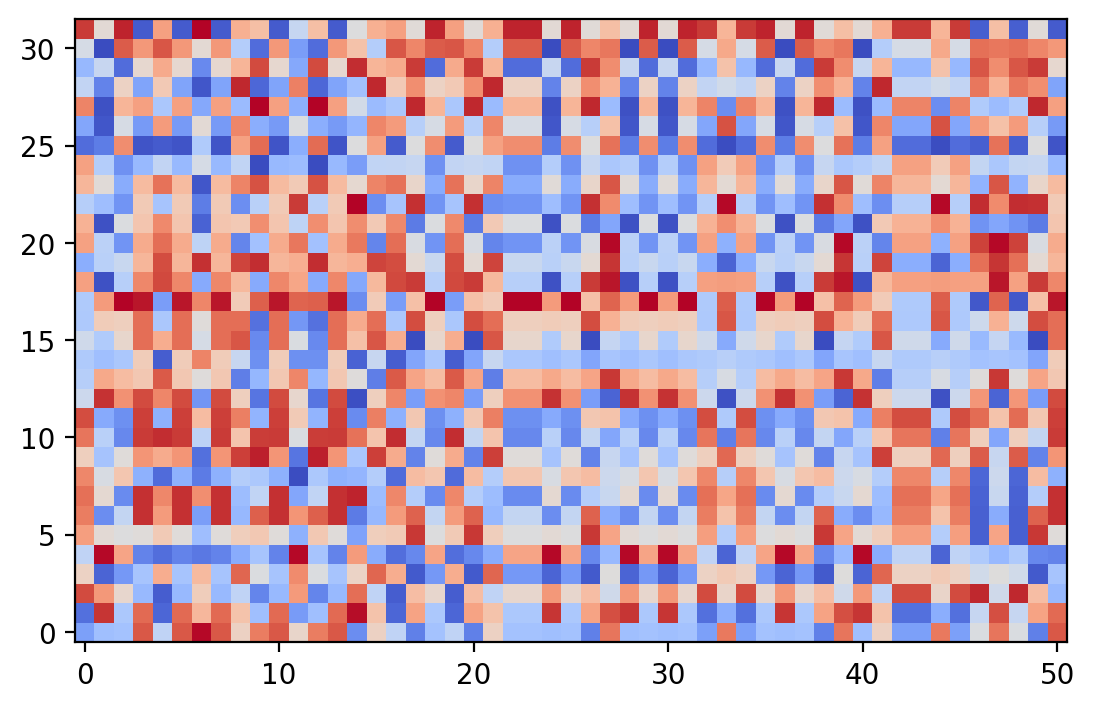

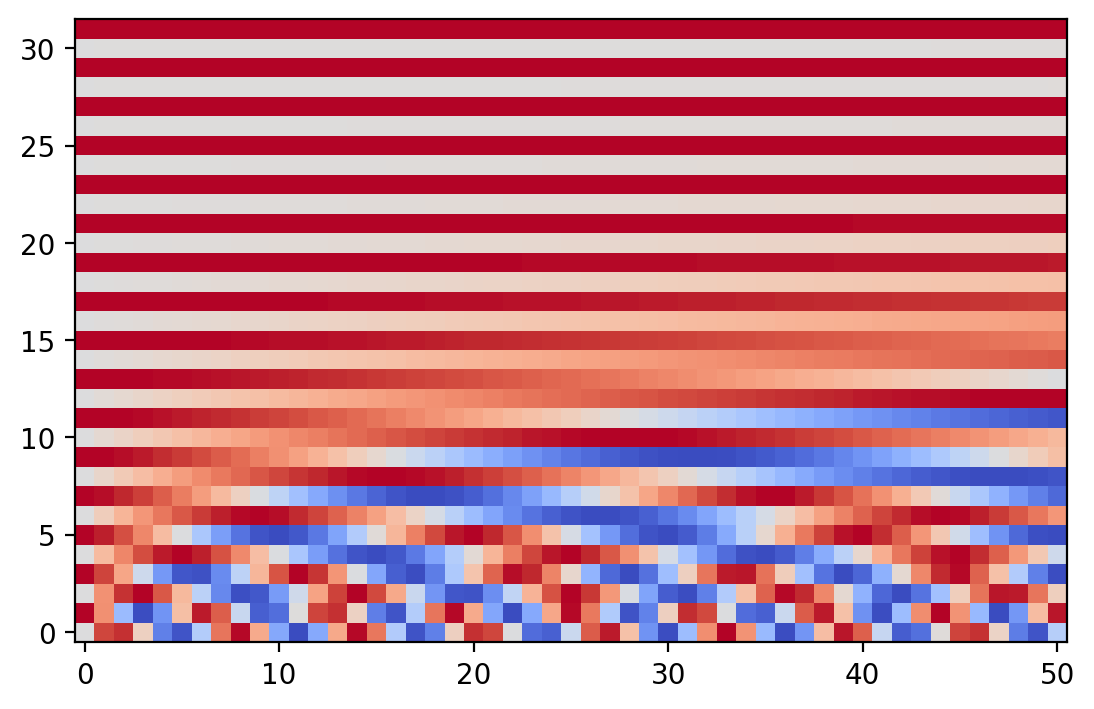

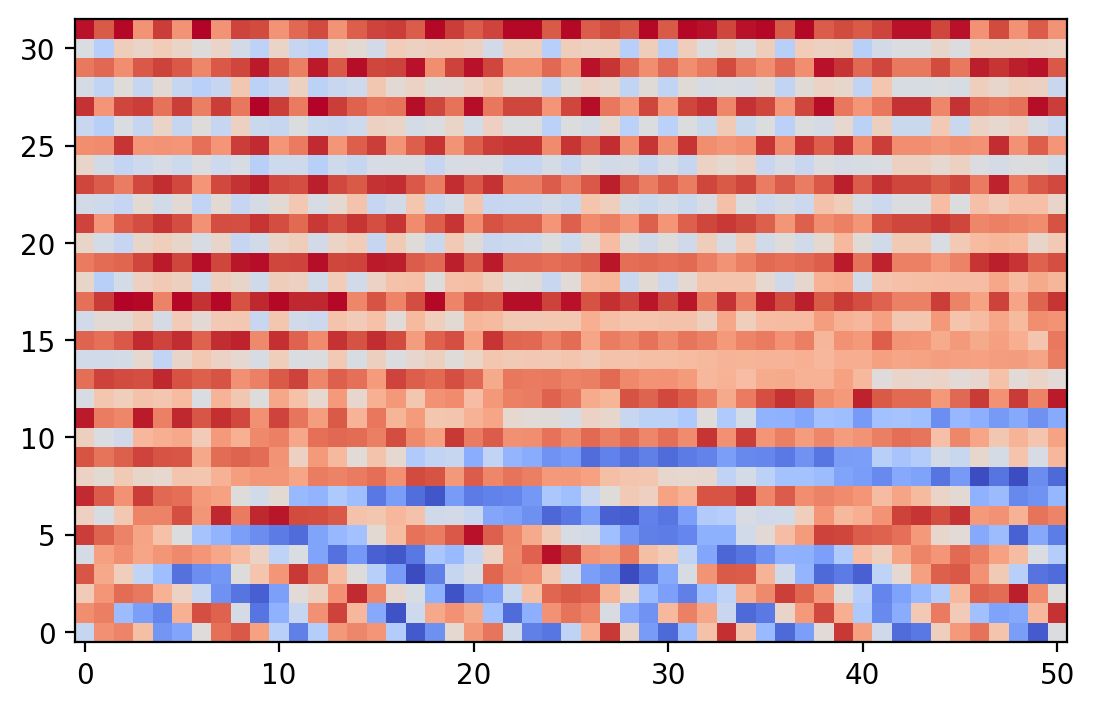

In [25]:
tpe = TokenAndPositionEmbedding(notes_vocab_size, 32)
token_embedding = tpe.token_emb(example_tokenised_notes)
position_embedding = tpe.pos_emb(token_embedding)
embedding = tpe(example_tokenised_notes)
plt.imshow(
    np.transpose(token_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(position_embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()
plt.imshow(
    np.transpose(embedding),
    cmap="coolwarm",
    interpolation="nearest",
    origin="lower",
)
plt.show()

In [26]:
note_inputs = layers.Input(shape=(None,), dtype=tf.int32)
durations_inputs = layers.Input(shape=(None,), dtype=tf.int32)
note_embeddings = TokenAndPositionEmbedding(
    notes_vocab_size, EMBEDDING_DIM // 2
)(note_inputs)
duration_embeddings = TokenAndPositionEmbedding(
    durations_vocab_size, EMBEDDING_DIM // 2
)(durations_inputs)
embeddings = layers.Concatenate()([note_embeddings, duration_embeddings])
x, attention_scores = TransformerBlock(
    N_HEADS, KEY_DIM, EMBEDDING_DIM, FEED_FORWARD_DIM, name="attention"
)(embeddings)
note_outputs = layers.Dense(
    notes_vocab_size, activation="softmax", name="note_outputs"
)(x)
duration_outputs = layers.Dense(
    durations_vocab_size, activation="softmax", name="duration_outputs"
)(x)
model = models.Model(
    inputs=[note_inputs, durations_inputs],
    outputs=[note_outputs, duration_outputs],  # attention_scores
)
model.compile(
    "adam",
    loss=[
        losses.SparseCategoricalCrossentropy(),
        losses.SparseCategoricalCrossentropy(),
    ],
)
att_model = models.Model(
    inputs=[note_inputs, durations_inputs], outputs=attention_scores
)

In [27]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          7,552 │ input_layer[0][0]      │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_and_position_embed… │ (None, None, 128)      │          3,072 │ input_layer_1[0][0]    │
│ (TokenAndPositionEmbeddi… │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, None, 256)      │              0 │ token_and_position_em… │
│                           │                        │                │ token_and_position_em… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention                 │ [(None, None, 256),    │      1,447,424 │ concatenate[0][0]      │
│ (TransformerBlock)        │ (None, 5, None, None)] │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ note_outputs (Dense)      │ (None, None, 59)       │         15,163 │ attention[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ duration_outputs (Dense)  │ (None, None, 24)       │          6,168 │ attention[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,479,379 (5.64 MB)

 Trainable params: 1,479,379 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
if LOAD_MODEL:
    model.load_weights("./checkpoint/checkpoint.ckpt")

## TASK 4
Training: Train the model on the processed data to learn the relationships between notes, durations, and musical structure.

In [43]:
import os
from music21 import environment, converter, stream, clef, chord, note, midi
from tensorflow import keras
from tensorflow.keras import callbacks, models
import numpy as np


# Replace any imports/functions in your existing MusicGenerator class
# to match the import statements above to ensure everything is consistent.

class MusicGenerator(callbacks.Callback):
    def __init__(self, index_to_note, index_to_duration, top_k=10):
        self.index_to_note = index_to_note
        self.note_to_index = {
            note: index for index, note in enumerate(index_to_note)
        }
        self.index_to_duration = index_to_duration
        self.duration_to_index = {
            duration: index for index, duration in enumerate(index_to_duration)
        }
        self._model = model
        self.generation_frequency = generation_frequency

    def sample_from(self, probs, temperature):
        probs = probs ** (1 / temperature)
        probs = probs / np.sum(probs)
        return np.random.choice(len(probs), p=probs), probs

    def get_note(self, notes, durations, temperature):
        sample_note_idx = 1
        while sample_note_idx == 1:
            sample_note_idx, note_probs = self.sample_from(
                notes[0][-1], temperature
            )
            sample_note = self.index_to_note[sample_note_idx]

        sample_duration_idx = 1
        while sample_duration_idx == 1:
            sample_duration_idx, duration_probs = self.sample_from(
                durations[0][-1], temperature
            )
            sample_duration = self.index_to_duration[sample_duration_idx]

        new_note = get_midi_note(sample_note, sample_duration) # Assuming get_midi_note is defined elsewhere

        return (
            new_note,
            sample_note_idx,
            sample_note,
            note_probs,
            sample_duration_idx,
            sample_duration,
            duration_probs,
        )

    def generate(self, start_notes, start_durations, max_tokens, temperature):
        attention_model = models.Model(
            inputs=self.model.input,
            outputs=self.model.get_layer("attention").output,
        )

        start_note_tokens = [self.note_to_index.get(x, 1) for x in start_notes]
        start_duration_tokens = [
            self.duration_to_index.get(x, 1) for x in start_durations
        ]
        sample_note = None
        sample_duration = None
        info = []
        midi_stream = stream.Stream()

        midi_stream.append(clef.BassClef())

        for sample_note, sample_duration in zip(start_notes, start_durations):
            new_note = get_midi_note(sample_note, sample_duration) # Assuming get_midi_note is defined elsewhere
            if new_note is not None:
                midi_stream.append(new_note)

        while len(start_note_tokens) < max_tokens:
            x1 = np.array([start_note_tokens])
            x2 = np.array([start_duration_tokens])
            notes, durations = self.model.predict([x1, x2], verbose=0)

            repeat = True

            while repeat:
                (
                    new_note,
                    sample_note_idx,
                    sample_note,
                    note_probs,
                    sample_duration_idx,
                    sample_duration,
                    duration_probs,
                ) = self.get_note(notes, durations, temperature)

                if (
                    isinstance(new_note, chord.Chord)
                    or isinstance(new_note, note.Note)
                    or isinstance(new_note, note.Rest)
                ) and sample_duration == "0.0":
                    repeat = True
                else:
                    repeat = False

            if new_note is not None:
                midi_stream.append(new_note)

            _, att = attention_model.predict([x1, x2], verbose=0)

            info.append(
                {
                    "prompt": [start_notes.copy(), start_durations.copy()],
                    "midi": midi_stream,
                    "chosen_note": (sample_note, sample_duration),
                    "note_probs": note_probs,
                    "duration_probs": duration_probs,
                    "atts": att[0, :, -1, :],
                }
            )
            start_note_tokens.append(sample_note_idx)
            start_duration_tokens.append(sample_duration_idx)
            start_notes.append(sample_note)
            start_durations.append(sample_duration)

            if sample_note == "START":
                break

        return info

    def on_epoch_end(self, epoch, logs=None):
        info = self.generate(
            ["START"], ["0.0"], max_tokens=GENERATE_LEN, temperature=0.5
        )
        midi_stream = info[-1]["midi"].chordify()
        print(info[-1]["prompt"])
        from music21 import environment
        env = environment.Environment()
        env['musicxmlPath'] = '/usr/bin/musescore3'
        env['musescoreDirectPNGPath'] = '/usr/bin/musescore3'
        midi_stream.show()
        midi_stream.write(
            "midi",
            fp=os.path.join(
                "/content/drive/My Drive/", # Changed from /drive/My Drive/
                "output-" + str(epoch).zfill(4) + ".mid",
            ),
        )

In [30]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5", # Change the filepath to end with .weights.h5
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

# Tokenize starting prompt
music_generator = MusicGenerator(notes_vocab, durations_vocab)

In [31]:
from music21 import environment

env = environment.Environment()
env['musicxmlPath'] = '/usr/bin/musescore3'
print(env['musicxmlPath'])

/usr/bin/musescore3


In [45]:
model.fit(
    ds,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        #music_generator,
    ],
)

Epoch 1/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - duration_outputs_loss: 0.5379 - loss: 1.5987 - note_outputs_loss: 1.0607
Epoch 2/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - duration_outputs_loss: 0.5436 - loss: 1.5629 - note_outputs_loss: 1.0193
Epoch 3/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - duration_outputs_loss: 0.4851 - loss: 1.5205 - note_outputs_loss: 1.0354
Epoch 4/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - duration_outputs_loss: 0.5145 - loss: 1.5691 - note_outputs_loss: 1.0546
Epoch 5/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - duration_outputs_loss: 0.5220 - loss: 1.5469 - note_outputs_loss: 1.0249
Epoch 6/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - duration_outputs_loss: 0.5755 - loss: 1.6351 - note_outputs_loss: 1.0595
Epoch 7/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - duration_outputs_loss: 0.5157 - loss: 1.5460 - note_outputs_loss: 1.0303
Epoch 8/100
201/201 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - duration_outputs_loss: 0.5408 - loss: 1.

## TASK 5

Music Generation: Use the trained model to generate new musical sequences that reflect the style of Bach's Cello Suites.

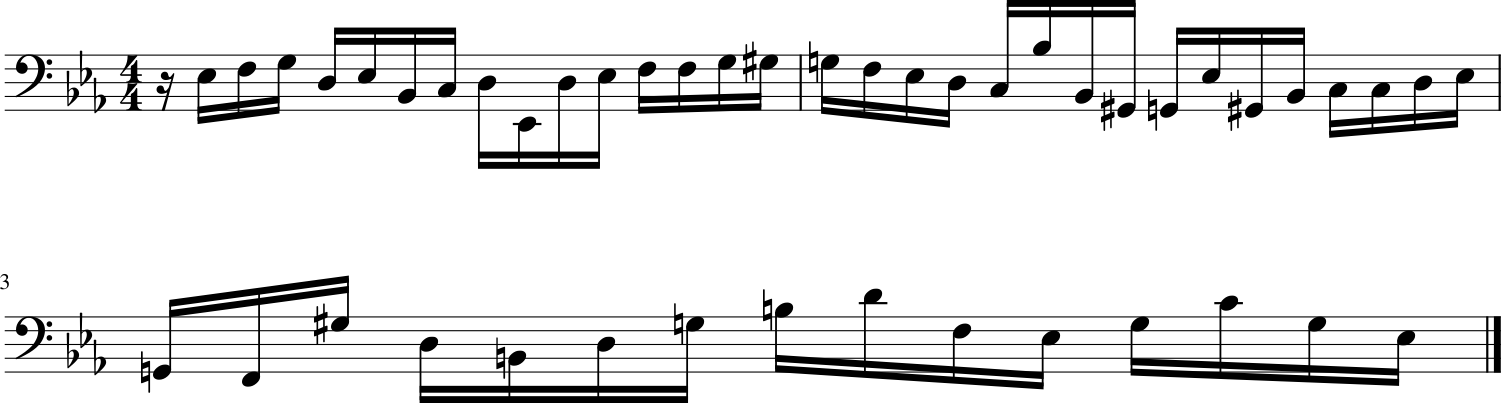

In [46]:
info = music_generator.generate(
    ["START"], ["0.0"], max_tokens=50, temperature=0.5
)
midi_stream = info[-1]["midi"].chordify()
midi_stream.show()

In [54]:
timestr = time.strftime("%Y%m%d-%H%M%S")
midi_stream.write(
    "midi",
    fp=os.path.join(
        "/content/drive/MyDrive",
        "cammisa-output3-" + timestr + ".mid",
    ),
)

'/content/drive/MyDrive/cammisa-output3-20241206-182204.mid'